# Extract lat/lon filenames without year

This notebook reads the ground-truth CSV for reference, scans a year-specific image
folder, and writes a new CSV where each filename is reduced to the `lat_lon.png`
format (year removed).

In [3]:
from pathlib import Path
import pandas as pd

CSV_PATH = Path(
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/"
    "FINAL_fcb_to_zigzag_MERGED_REVIEW_PRIORITY_WITH_MANUAL.csv"
)
IMG_DIR = Path(
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/"
    "data/delhi_airshed_y_2014_z_17_buf_25m"
)
NEG_DIR = Path(
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/"
    "data_neg/delhi_airshed_negatives_eas98_y_2025_z_17_buf_25m"
)
OUT_CSV = Path(
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/"
    "delhi_airshed_GrountdTruth.csv"
)

df = pd.read_csv(CSV_PATH)
print("Reference CSV rows:", len(df))
df.head(3)


Reference CSV rows: 753


,filename,class_name,Year_made,fcb to zigzag,Year_made_Category,fcb_to_zigzag_Category,manual_transition_year,reviewed
0,28.208668_77.420208.png,Zigzag,2018.0,2022.0,2018,2022.0,NaN,True
1,28.212481_77.401398.png,Zigzag,2018.0,2022.0,2018,2022.0,NaN,True
2,28.215068_77.424273.png,Zigzag,2018.0,2022.0,2018,2022.0,2022.0,True


In [3]:
def lat_lon_from_path(p: Path) -> str:
    """Extract lat_lon from filenames like 28.208668_77.420208_2014.png."""
    stem = p.stem
    return stem.rsplit("_", 1)[0]

pngs = sorted(IMG_DIR.glob("*.png"))
rows = []
for p in pngs:
    lat_lon = lat_lon_from_path(p)
    rows.append({"filename": f"{lat_lon}.png"})

out_df = (
    pd.DataFrame(rows)
    .drop_duplicates(subset=["filename"])
    .sort_values("filename")
    .reset_index(drop=True)
)

neg_pngs = sorted(NEG_DIR.glob("*.png"))
neg_rows = []
for p in neg_pngs:
    stem = p.stem
    base = stem.rsplit("_", 1)[0]
    neg_rows.append({"filename": f"{base}.png"})

neg_df = pd.DataFrame(neg_rows)
combined = pd.concat([out_df, neg_df], ignore_index=True)
combined = (
    combined.drop_duplicates(subset=["filename"])
    .sort_values("filename")
    .reset_index(drop=True)
)

year_df = pd.read_csv(
    CSV_PATH,
    usecols=[
        "filename",
        "class_name",
        "Year_made_Category",
        "fcb_to_zigzag_Category",
    ],
)
year_df["filename"] = year_df["filename"].astype(str).str.strip()
year_df = year_df.drop_duplicates(subset=["filename"])

combined["filename"] = combined["filename"].astype(str).str.strip()
merged = combined.merge(year_df, on="filename", how="left")

neg_set = set(neg_df["filename"].astype(str).str.strip())
neg_mask = merged["filename"].isin(neg_set)
merged.loc[neg_mask, "Year_made_Category"] = 0
merged.loc[neg_mask, "fcb_to_zigzag_Category"] = 0
merged.loc[neg_mask, "class_name"] = "negetive"
merged["Year_made_Category"] = pd.to_numeric(
    merged["Year_made_Category"], errors="raise"
).astype(int)
merged["fcb_to_zigzag_Category"] = pd.to_numeric(
    merged["fcb_to_zigzag_Category"], errors="raise"
).astype(int)

merged.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)
print(
    "GT rows:", len(out_df),
    "Neg rows:", len(neg_df),
    "Combined:", len(combined),
    "With categories:", len(merged),
)
merged.head()


Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/delhi_airshed_GrountdTruth.csv


,filename
0,28.208668_77.420208.png
1,28.212481_77.401398.png
2,28.215068_77.424273.png
3,28.216044_77.399816.png
4,28.219114_77.422602.png


In [1]:
!wc -l "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/delhi_airshed_GrountdTruth.csv"


925 /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/delhi_airshed_GrountdTruth.csv


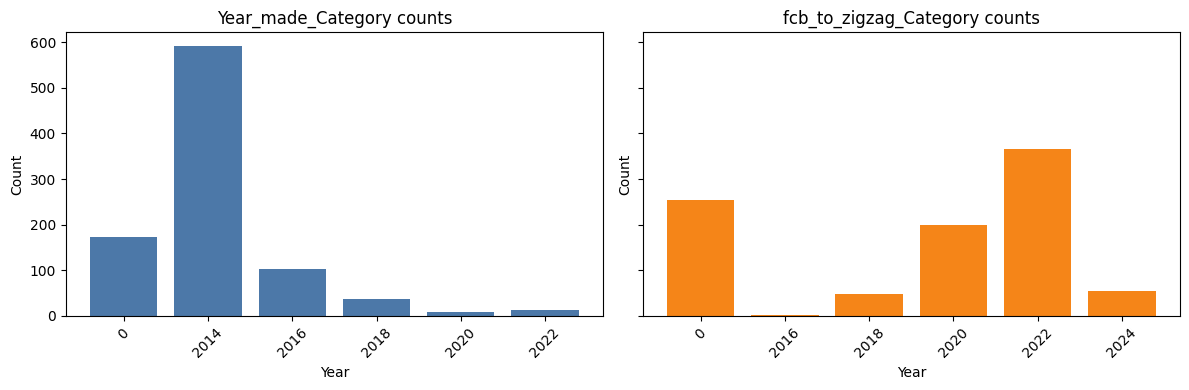

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
try:
    df_plot = merged.copy()
except NameError:
    df_plot = pd.read_csv(OUT_CSV)

cols = ["Year_made_Category", "fcb_to_zigzag_Category"]
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
colors = ["#4C78A8", "#F58518"]

for ax, col, color in zip(axes, cols, colors):
    counts = df_plot[col].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values, color=color)
    ax.set_title(f"{col} counts")
    ax.set_xlabel("Year")
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


In [7]:
%%bash
NEG_DIR="/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data_neg/delhi_airshed_negatives_eas98_y_2025_z_17_buf_25m"
LABEL_DIR="/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m_labels"

for img in "$NEG_DIR"/*.png; do
  base=$(basename "$img" .png)
  touch "$LABEL_DIR/$base.txt"
done

echo "Total label .txt:" $(find "$LABEL_DIR" -maxdepth 1 -name "*.txt" | wc -l)
echo "Non-empty labels:" $(find "$LABEL_DIR" -maxdepth 1 -name "*.txt" -size +0c | wc -l)
echo "Empty labels:" $(find "$LABEL_DIR" -maxdepth 1 -name "*.txt" -size 0c | wc -l)


Total label .txt: 925
Non-empty labels: 751
Empty labels: 174


In [8]:
%%bash
SRC_IMG_DIR="/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m"
SRC_LBL_DIR="/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m_labels"
DST_ROOT="/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m_symlink"
DST_IMG_DIR="$DST_ROOT/images"
DST_LBL_DIR="$DST_ROOT/labels"

rm -rf "$DST_ROOT"
mkdir -p "$DST_IMG_DIR" "$DST_LBL_DIR"

for f in "$SRC_IMG_DIR"/*.png; do
  [ -e "$f" ] || continue
  ln -s "$f" "$DST_IMG_DIR/$(basename "$f")"
done

for f in "$SRC_LBL_DIR"/*.txt; do
  [ -e "$f" ] || continue
  ln -s "$f" "$DST_LBL_DIR/$(basename "$f")"
done

echo "Source images:" $(ls -1 "$SRC_IMG_DIR"/*.png 2>/dev/null | wc -l)
echo "Source labels:" $(ls -1 "$SRC_LBL_DIR"/*.txt 2>/dev/null | wc -l)
echo "Symlink images:" $(ls -1 "$DST_IMG_DIR"/*.png 2>/dev/null | wc -l)
echo "Symlink labels:" $(ls -1 "$DST_LBL_DIR"/*.txt 2>/dev/null | wc -l)


Source images: 924
Source labels: 925
Symlink images: 924
Symlink labels: 925


## YOLO12maa training and inference

Example commands:

```bash
python train_yolo12m_2025.py --model yolo12m.pt\n
python infer_yolo12m_other_years.py --weights runs/detect/yolo12m_2025/weights/best.pt --save --save-txt\n
```


In [ ]:
%%bash
python /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/yolo_prediction_appearance_year.py \
  --pred-root /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/runs/detect \
  --data-root /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data \
  --years 2014,2016,2018,2020,2022,2024 \
  --out-csv /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/yolo_prediction.csv
echo "Columns: filename, appearance_year, Transition_year, class_name"


In [ ]:
%%bash
python /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/evaluate_yolo_predictions.py \
  --gt-csv /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/delhi_airshed_GrountdTruth.csv \
  --pred-csv /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/yolo_prediction.csv
